# ACSE 4.4 - Identification Game with ResNet152

### Initialization

Only run this if opened in Google Colab, to mount Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Setup & Imports

In [0]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 61kB 2.7MB/s 
     |████████████████████████████████| 552kB 13.0MB/s 
Populating the interactive namespace from numpy and matplotlib


In [0]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from livelossplot import PlotLosses
from pycm import *
import torch.nn as nn
import torch.nn.functional as F

### Initialise dataset
These files are prepared in advance since it takes a long time to transform images to torch tensors. The tensors are downloaded and stored on memory.

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Downloads test dataset as image tensors
file_id = '1sx-ZMwAhwTkwXNfzqFrSnwOa6MapL6DA'
destination = './X_data.py'
download_file_from_google_drive(file_id, destination)

# Downloads targets
file_id = '1qT7fFErlWHBhEbJBIAyjQ7Kj8iGoTOuL'
destination = './y_data.py'
download_file_from_google_drive(file_id, destination)

In [0]:
X_train_all = torch.load('/content/gdrive/My Drive/Kaggle/Copy of X_train_all.py') # all images in train file
y_train_all = torch.load('/content/gdrive/My Drive/Kaggle/Copy of y_train_all.py') # all labels in train file
mean_list = torch.tensor([0.4802, 0.4481, 0.3975])
std_list = torch.tensor([0.2770, 0.2691, 0.2821])

# Check variables
print(mean_list)
print(std_list)
print(X_train_all.shape)
print(y_train_all.shape)

tensor([0.4802, 0.4481, 0.3975])
tensor([0.2770, 0.2691, 0.2821])
torch.Size([100000, 3, 64, 64])
torch.Size([100000])


#### Sanity check

In [0]:
print(X_train_all.max(), X_train_all.min())

tensor(1.) tensor(0.)


Stratify the dataset

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) 
spt = sss.split(X_train_all, y_train_all)

# Get the indices of the split data
indices = [(train_idx, validation_idx) for train_idx, validation_idx in spt][0]

In [0]:
# Split data into training set and validation set
X_train, y_train = X_train_all[indices[0]], y_train_all[indices[0]]
X_val, y_val = X_train_all[indices[1]], y_train_all[indices[1]]

# Check the size of the dataset
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)
print(X_train.max())

torch.Size([90000, 3, 64, 64]) torch.Size([10000, 3, 64, 64])
torch.Size([90000]) torch.Size([10000])
tensor(1.)


### Create custom dataset

In [0]:
from torch.utils.data import Dataset
from PIL import Image

# Custom Dataset for performing image transformations on the data
class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data: array-like containing the data
            targets: array-like containing the targets
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

### Data augmentation
We resize the original pritures to 224*224 to fit the ResNet152 structure.

In [0]:
from torchvision.transforms import *

# Transformations
# According to the second coursework, we find rotation 10 degrees and right-left flip works best
train_transform = Compose([ToPILImage(),
                           transforms.Resize(224),
                           RandomRotation(10),
                           RandomHorizontalFlip(p=0.5),
                           ToTensor(),
                           Normalize(mean_list, std_list)])

# In Validation and Test Mode we only want to normalize and resize our images
validation_test_transform = Compose([ToPILImage(),
                                     transforms.Resize(224),
                                     ToTensor(),
                                     Normalize(mean_list, std_list)])

### Create Dataloader for training and validation 

In [0]:
# Create the custom datasets with the transformations
train_data = CustomDataset(X_train, y_train.long(), transform=train_transform)
val_data = CustomDataset(X_val, y_val.long(), transform=validation_test_transform)
train_all_data = CustomDataset(X_train_all, y_train_all.long(), transform=train_transform)

# Free up memory
del X_train_all
del y_train_all

batch_size = 256
test_batch_size = 256

# Create the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=test_batch_size, shuffle=False, num_workers=2, pin_memory=True)
train_all_loader = torch.utils.data.DataLoader(train_all_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

## Initialize ResNet152
We choose the most advanced CNN which is trained on ImageNet. We've tried many models, by only fix the last layer's output size into 200 at first to see the general performance of AlexNet, ResNet50 and ResNet152. For each of them, it achieved the accuracy around 60%, 65% and 68%. So we chose ResNet152 for further development. 

To further fix the whole layers, we added a new layer at the end, from 1000 classes to 200 classes with dropout(0.3) and ReLU activation. In this way, our new model's computational cost is acceptable, and the accuracy is expected to be better.

Compared with SGD, we found Adam can adapt to the model better and make it quicker. 

It seems that the bigger the batch size we set, the better performance we can get. But actually, it turns out to be the best when the batch size is 256 compared with 32, 64, 128 and 512. So we set the batch size as 256.

We also found it hinders performance to set the learning rate as a fixed number, so we scheduled it to halve the learning rate every 5 epochs starting from 1e-3 to avoid getting stuck in local minima. It turned out that worked quite well.

In [0]:
import torch.nn as nn
import torchvision.models as models

model = models.resnet152(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

model = nn.Sequential(model, nn.Dropout(0.3), nn.ReLU(),  nn.Linear(1000,200))
model = model.cuda()

# optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5,0.5)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [0]:
# show the structure of the updated model
model.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)



---



### Preparing for training session

In [0]:
# This part are computing the accuracy. It is able to compute top-1 and top-5 accuracy if needed.
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self, name, fmt=':f'):
    self.name = name
    self.fmt = fmt
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

  def __str__(self):
    fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
    return fmtstr.format(**self.__dict__)

def accuracy(output, target, topk=(1,)):
  """Computes the accuracy over the k top predictions for the specified values of k"""
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    res.append(correct_k.mul_(100.0 / batch_size))
  return res

        
def train(train_loader, model, criterion, optimizer, liveloss):
  batch_time = AverageMeter('Time', ':6.3f')
  data_time = AverageMeter('Data', ':6.3f')
  losses = AverageMeter('Loss', ':.4e')
  top1 = AverageMeter('Acc@1', ':6.2f')
  top5 = AverageMeter('Acc@5', ':6.2f')

  # We still use evaluation mode since we don't want to change any weights of the pretrained model. We only
  # need to change the weights of the added layer.
  model.eval()

  end = time.time()
  for i, (images, target) in enumerate(train_loader):
    # measure data loading time
    data_time.update(time.time() - end)
    images = images.cuda(non_blocking=True)
    target = target.cuda(non_blocking=True)

    # compute output
    output = model(images)
    loss = criterion(output, target)

    # measure accuracy and record loss
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    losses.update(loss.item(), images.size(0))
    top1.update(acc1[0], images.size(0))
    top5.update(acc5[0], images.size(0))

    # compute gradient and do SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # measure elapsed time
    batch_time.update(time.time() - end)
    end = time.time()

  liveloss.update({'loss':losses.avg, 'acc':top1.avg})
  liveloss.draw()
  return losses.avg, top1.avg

def validate(val_loader, model, criterion, liveloss):
  batch_time = AverageMeter('Time', ':6.3f')
  losses = AverageMeter('Loss', ':.4e')
  top1 = AverageMeter('Acc@1', ':6.2f')
  top5 = AverageMeter('Acc@5', ':6.2f')
  # switch to evaluate mode
  model.eval()
  with torch.no_grad():
    end = time.time()
    for i, (images, target) in enumerate(val_loader):
      images = images.cuda(non_blocking=True)
      target = target.cuda(non_blocking=True)
      # compute output
      output = model(images)
      loss = criterion(output, target)
      # measure accuracy and record loss
      acc1, acc5 = accuracy(output, target, topk=(1, 5))
      losses.update(loss.item(), images.size(0))
      top1.update(acc1[0], images.size(0))
      top5.update(acc5[0], images.size(0))
      # measure elapsed time
      batch_time.update(time.time() - end)
      end = time.time()
    liveloss.update({'val_loss':losses.avg, 'val_acc':top1.avg})
    liveloss.draw()
  return losses.avg, top1.avg


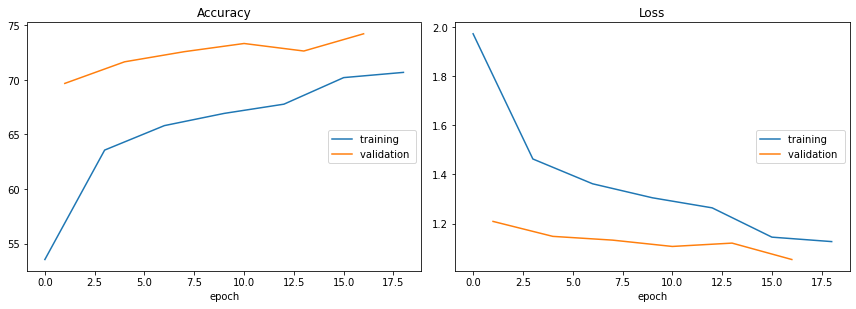

Accuracy
	training         	 (min:   53.533, max:   70.691, cur:   70.691)
	validation       	 (min:   69.680, max:   74.230, cur:   74.230)
Loss
	training         	 (min:    1.126, max:    1.973, cur:    1.126)
	validation       	 (min:    1.053, max:    1.209, cur:    1.053)


KeyboardInterrupt: ignored

In [0]:
# Train and validate the model with the split data
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5,0.5)

logs = {}
liveloss = PlotLosses()
for epoch in range(90):
    train_loss, train_accuracy = train(train_loader, model, criterion, optimizer, liveloss)
    

    # logs['' + 'log loss'] = train_loss
    # logs['' + 'accuracy'] = train_accuracy

    validation_loss, validation_accuracy = validate(val_loader, model, criterion, liveloss)
    # logs['val_' + 'log loss'] = validation_loss
    # logs['val_' + 'accuracy'] = validation_accuracy
    scheduler.step()

    liveloss.update(logs)
    liveloss.draw()

## Train on the full training set

For our final submission on Kaggle, we interrupted the training at 28 epochs, since there is no significant improvement in test accuracy after that.

In [0]:
criterion = nn.CrossEntropyLoss()
logs = {}
liveloss = PlotLosses()


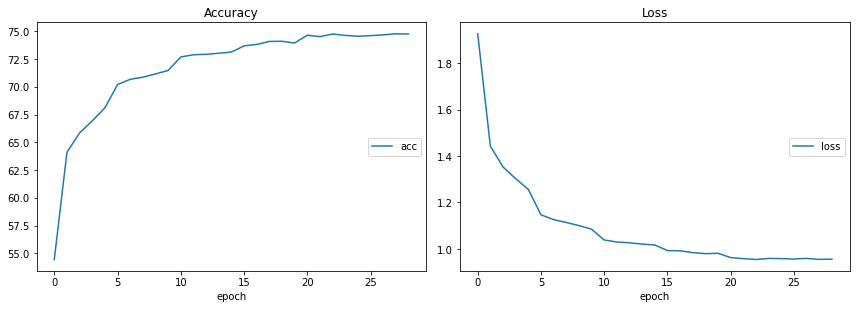

Accuracy
	acc              	 (min:   54.437, max:   74.771, cur:   74.748)
Loss
	loss             	 (min:    0.954, max:    1.927, cur:    0.955)


KeyboardInterrupt: ignored

In [0]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5,0.5)

for epoch in range(90):
    train_loss, train_accuracy = train(train_all_loader, model, criterion, optimizer, liveloss)
    scheduler.step()

In [0]:
# Check macro F1-score for the validation set
from sklearn.metrics import f1_score

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X = X.cuda(non_blocking=True)
            y = y.cuda(non_blocking=True)
          # compute output
            output = model(X)
            y_pred = F.log_softmax(output, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)


In [0]:
val_ypred, y_val = evaluate(model, val_loader)
val_f1 = f1_score(y_val, val_ypred, average='macro')
print(val_f1)

0.8109558300984665


## Save the trained model.

In [0]:
# torch.save(model, '/content/gdrive/My Drive/Kaggle/resnet152_new.pt')

## Load the trained model.

In [0]:
# model = torch.load('/content/gdrive/My Drive/Kaggle/resnet152_new.pt')

## Test model and save the result

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# The test images were stored in our own Google Drive.
# However, they can be downloaded and transformed in a similar method as the training dataset above. 
test_dataset = ImageFolder('/content/gdrive/My Drive/Kaggle/test', transforms.Compose([
            transforms.Resize(256),
            transforms.FiveCrop(224),
            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
        ]))
test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=64, shuffle=False, drop_last=False,
        num_workers=8)

def test(test_loader, model):
  pred = None
  # switch to evaluate mode
  model.eval()
  with torch.no_grad():
    end = time.time()
    for i, (images, target) in enumerate(test_loader):
      images = images.cuda()
      bs, ncrops, c, h, w = images.size()
      # target = target.cuda(non_blocking=True)
      # compute output
      temp_output = model(images.view(-1, c, h, w))
      outputs = temp_output.view(bs, ncrops, -1).mean(1)
      prediction = torch.max(outputs, 1)
      # measure accuracy and record loss
      pred = prediction if pred is None else torch.cat([pred, prediction])
  return pred

In [0]:
test_y = test(test_loader, model)

In [0]:
# Create and write submission csv file
import csv
with open('./submissionfile_resnet152_new.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["Filename", "Label"])
  for i in range(10000):
      writer.writerow([test_dataset.samples[i][0].split('/')[-1].replace('JPEG','jpeg'), str(int(test_y[i]))])